# Task 2 - Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
#Import neccessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
#Load dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [5]:
df.shape

(2035, 8)

In [6]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')

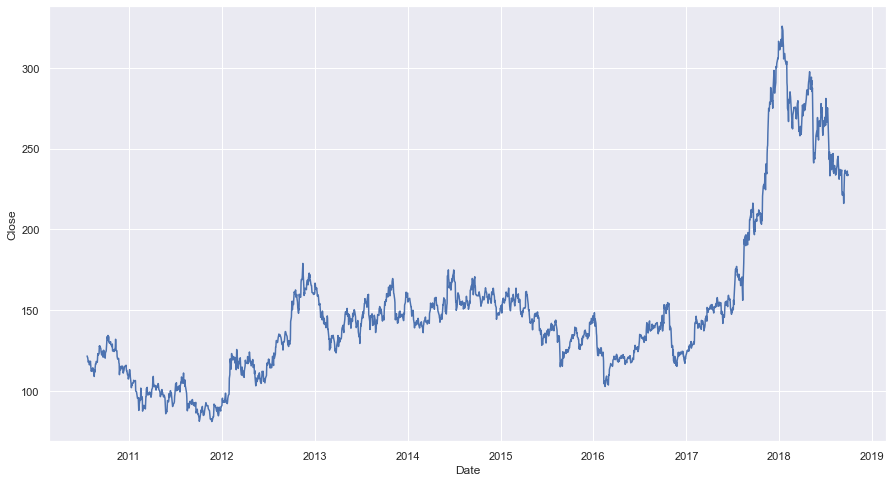

In [9]:
plt.figure(figsize=(15,8))
sns.lineplot(df['Date'],df['Close']);

In [10]:
df1 = df.reset_index()['Close']

In [11]:
df1

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [14]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
print('Training size:',training_size)
print('Training size:',test_size)

Training size: 1322
Training size: 713


In [16]:
train_data

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.25347222],
       [0.26041667],
       [0.2563317 ]])

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape) 
print(y_train.shape)

(1221, 100)
(1221,)


In [20]:
print(X_test.shape)
print(ytest.shape)

(612, 100)
(612,)


In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 9s 215ms/step - loss: 0.0290 - val_loss: 0.0033
Epoch 2/100
20/20 [==============================] - 3s 136ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/100
20/20 [==============================] - 3s 158ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/100
20/20 [==============================] - 3s 132ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/100
20/20 [==============================] - 3s 129ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
20/20 [==============================] - 3s 130ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/100
20/20 [==============================] - 3s 132ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/100
20/20 [==============================] - 3s 142ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/100
20/20 [==============================] - 3s 138ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
20/20 [==============================] - 3s 134ms/step - loss: 0.0012 - val_lo

In [25]:
#Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [26]:
#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [27]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

163.51103486900945

In [28]:
#Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

115.54879562821303

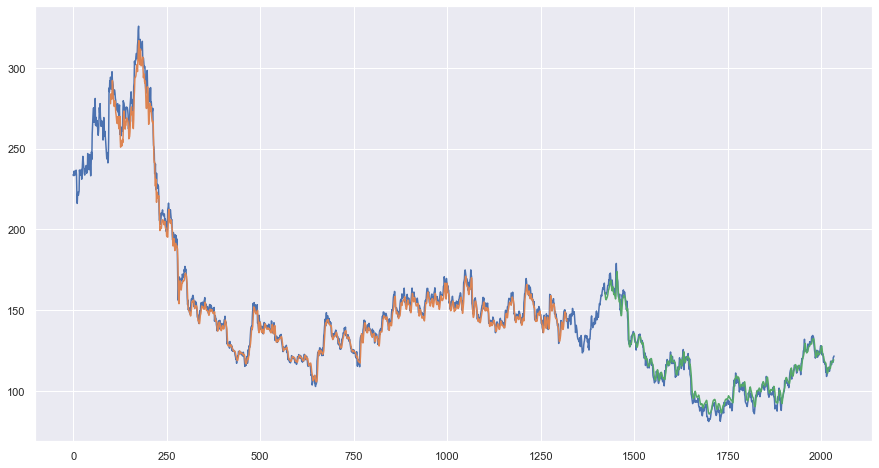

In [30]:
#Prediction

#Plotting 
#shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
#plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
len(test_data) , X_test.shape

(713, (612, 100, 1))

In [32]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 372)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input[:10]

[0.048815359477124176,
 0.048815359477124176,
 0.05310457516339867,
 0.049632352941176405,
 0.05065359477124176,
 0.05126633986928103,
 0.049632352941176405,
 0.05902777777777779,
 0.055555555555555525,
 0.040849673202614345]

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [36]:
len(df1)

2035

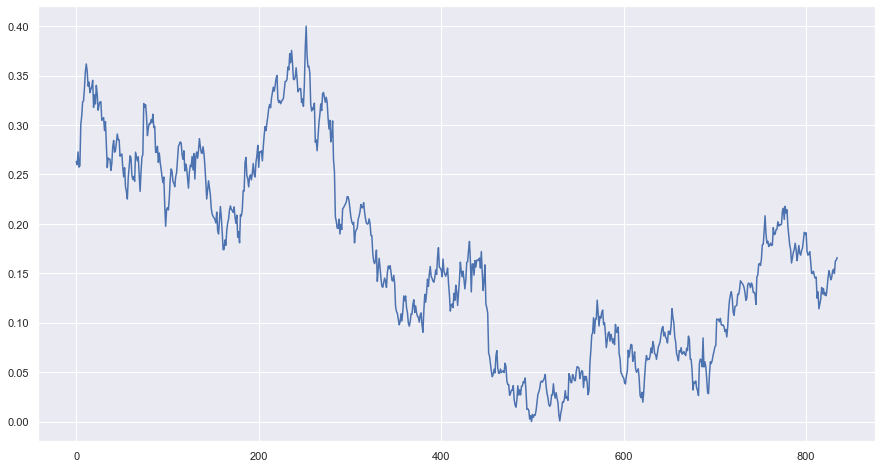

In [37]:
df3=df1.tolist()
plt.figure(figsize=(15,8))
plt.plot(df3[1200:])

In [38]:
df3=scaler.inverse_transform(df3).tolist()

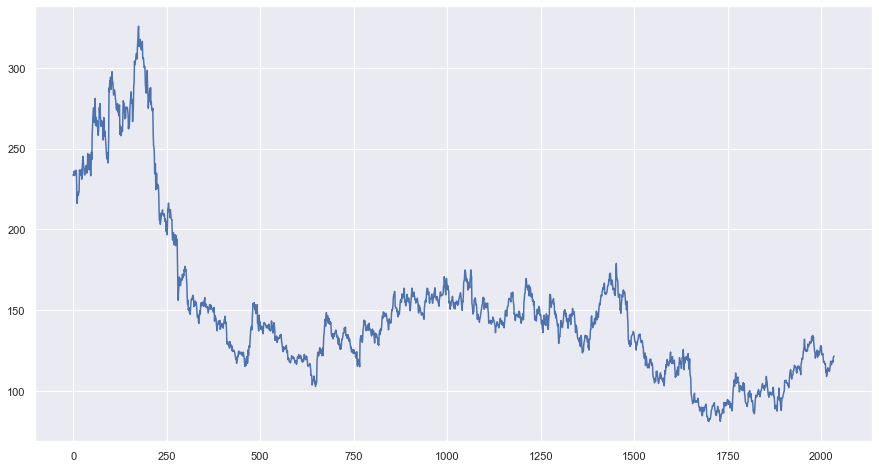

In [39]:
plt.figure(figsize=(15,8))
plt.plot(df3)